In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import isnan

sns.set()

In [21]:
output_file = 'results/OzoneCrossVal/results_nn_optimizing_bs_and_lr'

output_file_2 = 'results/OzoneCrossVal/results_final'

total_metrics = pd.read_csv(f'{output_file}.csv')
total_metrics_2 = pd.read_csv(f'{output_file_2}.csv')

total_metrics_2 = total_metrics_2[(total_metrics_2.model_name!='dense')]

total_metrics = pd.concat((total_metrics, total_metrics_2))
total_metrics["n_features"] = total_metrics.selected_features.apply(eval).apply(len)
#total_metrics["selection_params_residual"] = total_metrics.selection_params_residual.fillna(False)

In [22]:
total_metrics['model_name'] = total_metrics['model_name'].replace({'decisiontree': 'DT'})
total_metrics['selection_name'] = total_metrics['selection_name'].replace({'NoSelection': 'NS', 'TimeSelectionLayer': 'TSL'})

total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.model_name=='lstm'), 'model_name'] = 'TSL_LSTM'
total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.model_name=='dense'), 'model_name'] = 'TSL_FF'
total_metrics.loc[total_metrics.selection_name=='TimeSelectionLayerConstant', 'model_name'] = 'TSL*'
#total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.selection_params_residual), 'model_name'] = 'TSLRes'
total_metrics['model_name'] = total_metrics['model_name'].replace({'dense': 'FF', 'lasso': 'L1'})
total_metrics['dataset'] = total_metrics['dataset'].apply(lambda x: x.capitalize()).replace({'Rondadelvalle': 'Ronda del valle'})
total_metrics.drop("dataset_name", inplace=True, axis=1)

In [23]:
model_params = [col for col in total_metrics.columns if 'model_params' in col or 'selection_params' in col]
grouped = total_metrics.groupby(['dataset', 'selection_name', 'model_name', *model_params], dropna=False)[["root_mean_squared_error_valid"]].mean()
best_index = grouped.loc[grouped.groupby(['dataset', 'selection_name', 'model_name', 'selection_params_residual'], dropna=False).root_mean_squared_error_valid.idxmin()].index

total_metrics_indexed = total_metrics.set_index(['dataset', 'selection_name', 'model_name',*model_params])

best_by_year = total_metrics_indexed.loc[best_index, ['root_mean_squared_error', 'mean_absolute_error', 'dataset_params_test_year', 'features', 'selected_features']].reset_index()

best_by_year[best_by_year.dataset_params_test_year>2005].groupby(['dataset', 'model_name'], dropna=False)[["root_mean_squared_error"]].mean().reset_index().pivot(index = 'dataset', columns='model_name', values='root_mean_squared_error')#.to_latex()

model_name,DT,FF,L1,TSL_FF,TSL_LSTM,lstm
dataset,,,,,,
Aljarafe,17.171618,17.019767,16.666747,16.670537,16.324708,16.492465
Asomadilla,17.321076,17.276939,16.338111,16.513144,16.266460,16.568526
Bermejales,19.264402,18.946476,18.220908,18.139151,18.112180,18.520877
Ronda del valle,20.244155,19.194717,18.672663,18.431709,18.260098,18.706682
Torneo,14.978726,14.619907,14.143445,14.000398,14.018860,14.093802


<Figure size 2000x2000 with 0 Axes>

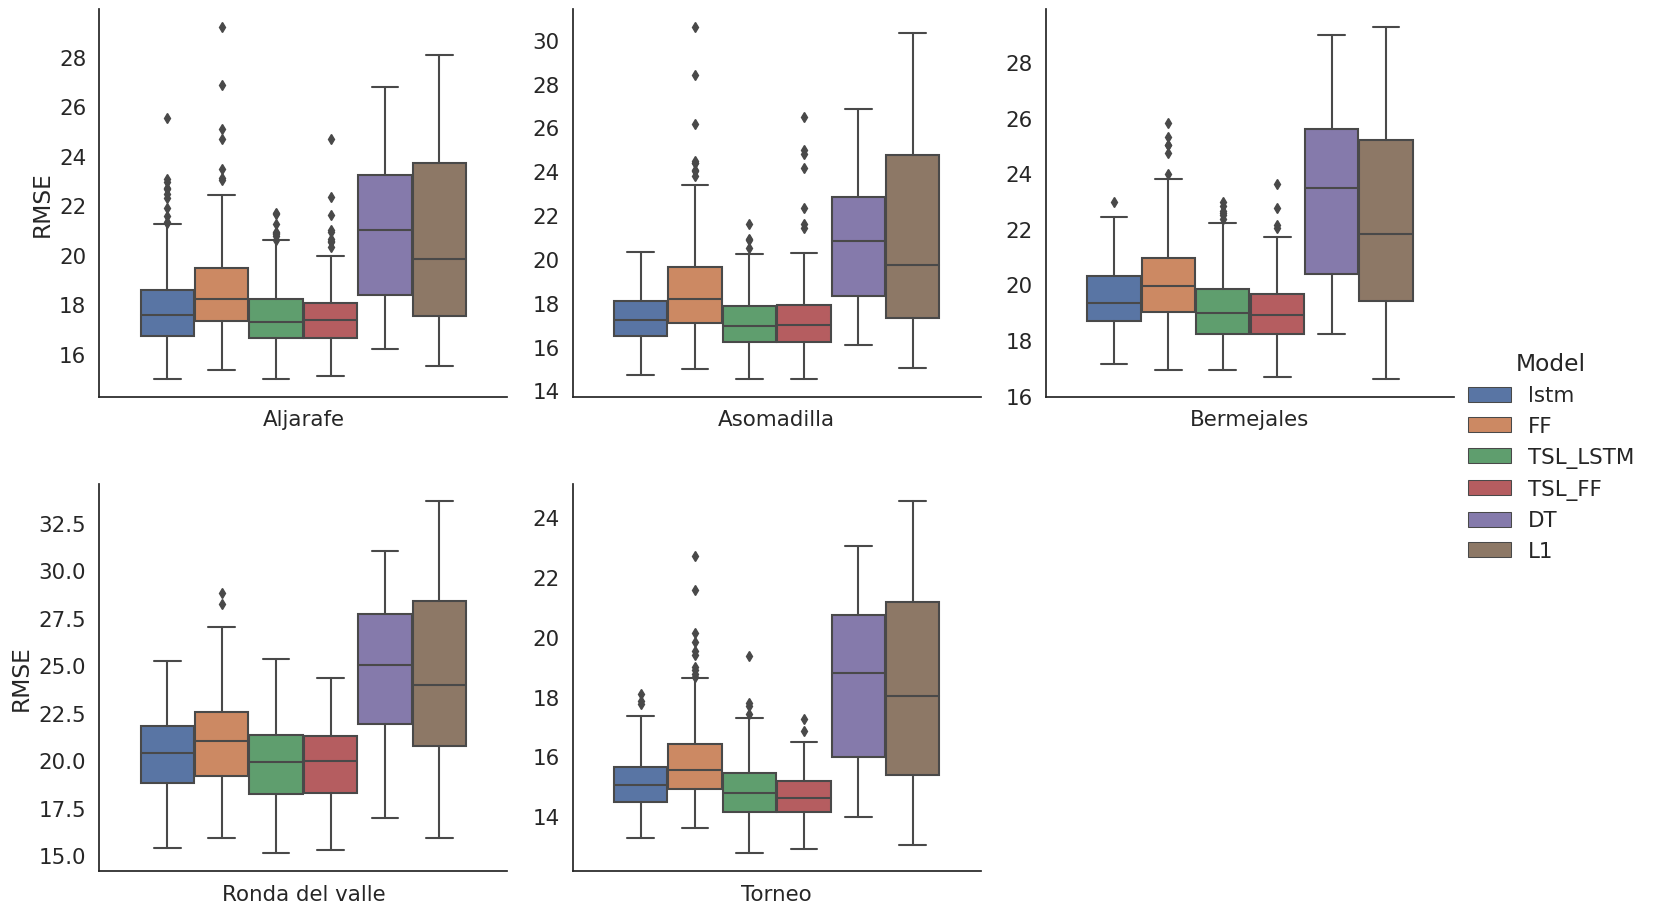

In [24]:
sns.set(font_scale=1.4, style='white')
plt.figure(figsize=(20,20))
#total_metrics.loc[:, 'selection_params_residual'] = total_metrics.loc[:, 'selection_params_residual'].fillna(False)
total_metrics = total_metrics.rename({'model_name': 'Model', 'root_mean_squared_error': 'RMSE', 'n_features': '# Features'}, axis=1)
g = sns.catplot(data=total_metrics, kind='box', x='dataset', y="RMSE", col='dataset', hue='Model', sharex=False, sharey=False, col_wrap=3, legend=True)#.set_yscale("log")
g.set(xlabel=None)
g.set_titles(template='')
plt.show()

<Figure size 2000x2000 with 0 Axes>

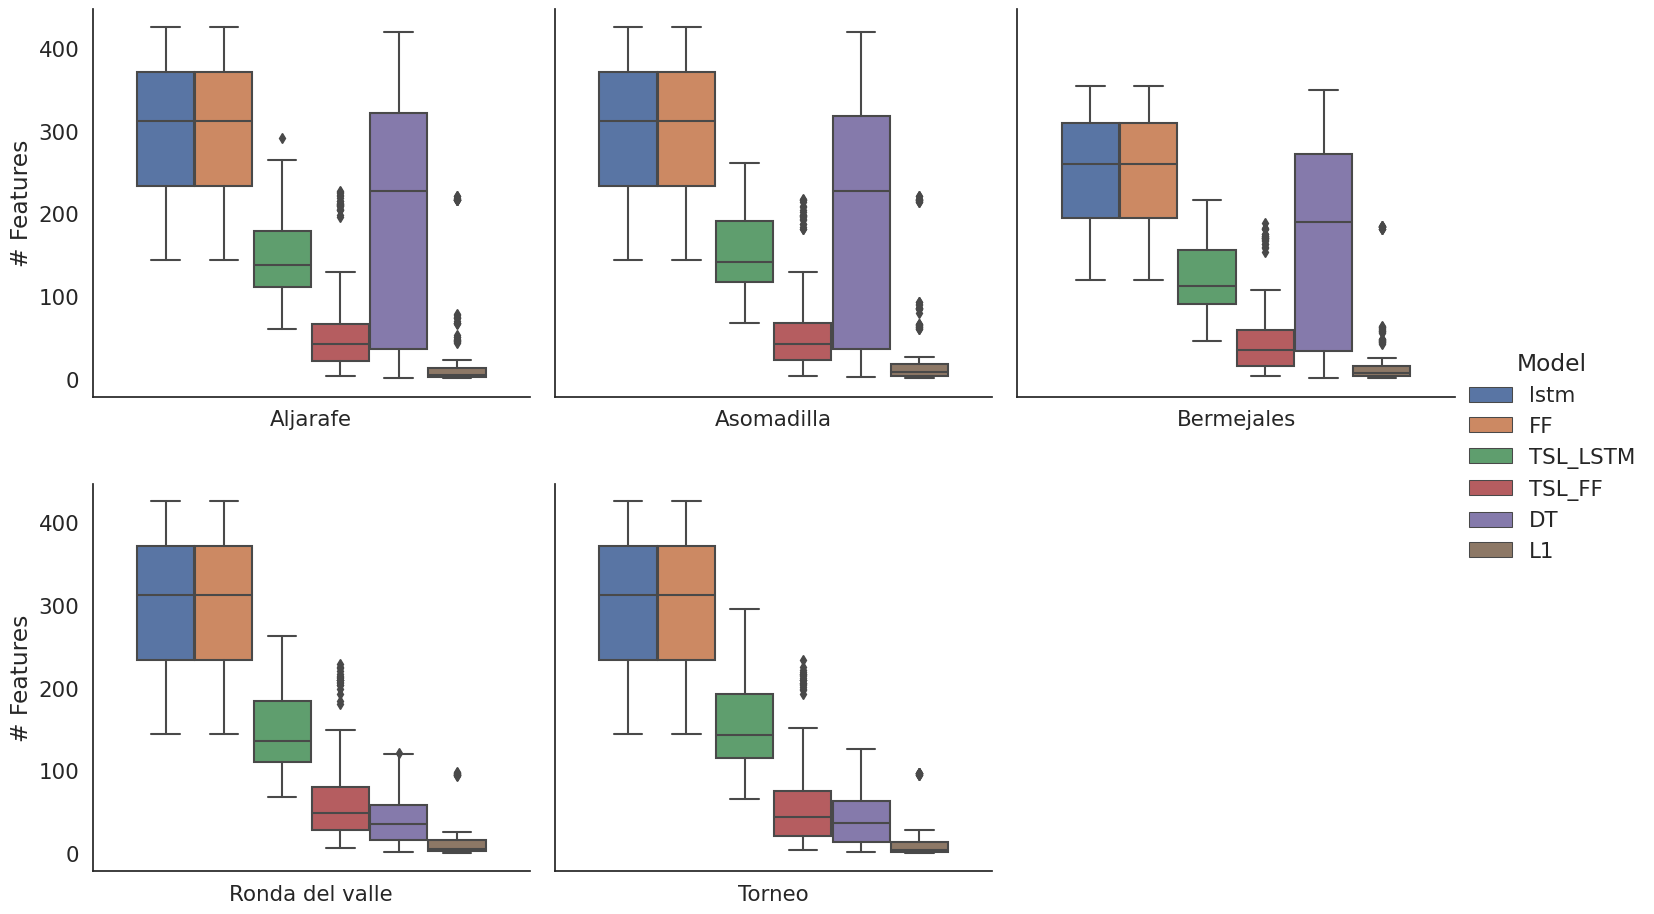

In [25]:
sns.set(font_scale=1.4, style='white')
plt.figure(figsize=(20,20))
total_metrics.loc[:, 'selection_params_residual'] = total_metrics.loc[:, 'selection_params_residual'].fillna(False)

g = sns.catplot(data=total_metrics[(total_metrics.dataset_params_test_year>2005)], kind='box', x='dataset', y="# Features", col='dataset', hue='Model', sharex=False, col_wrap=3, legend=True)#.set_yscale("log")
g.set(xlabel=None)
g.set_titles(template='')
plt.savefig('figures/boxplot_Features.png')
plt.show()
plt.show()

## Selection masks

0.15040650406504066
0.09183673469387756
0.09795918367346938
0.15217391304347827
0.14492753623188406


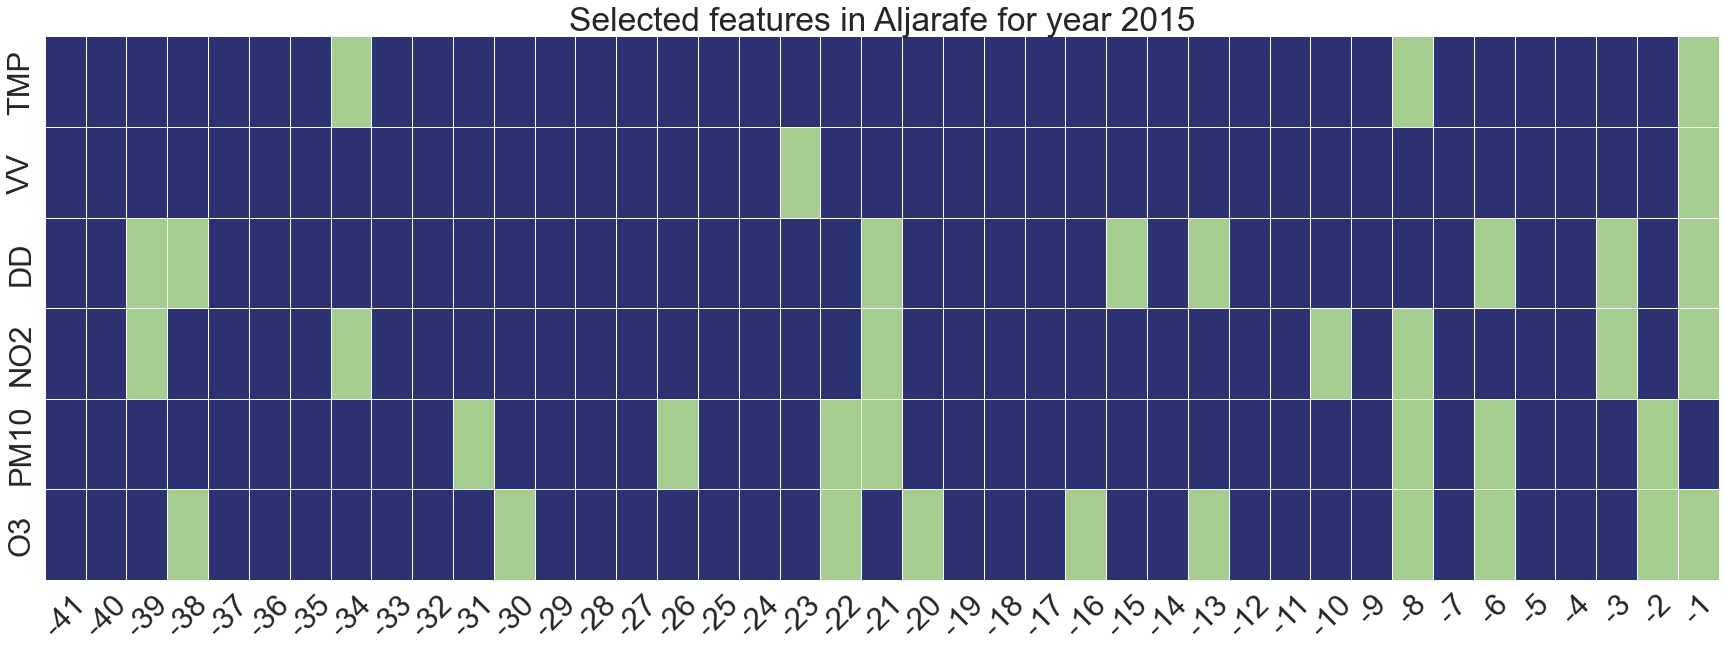

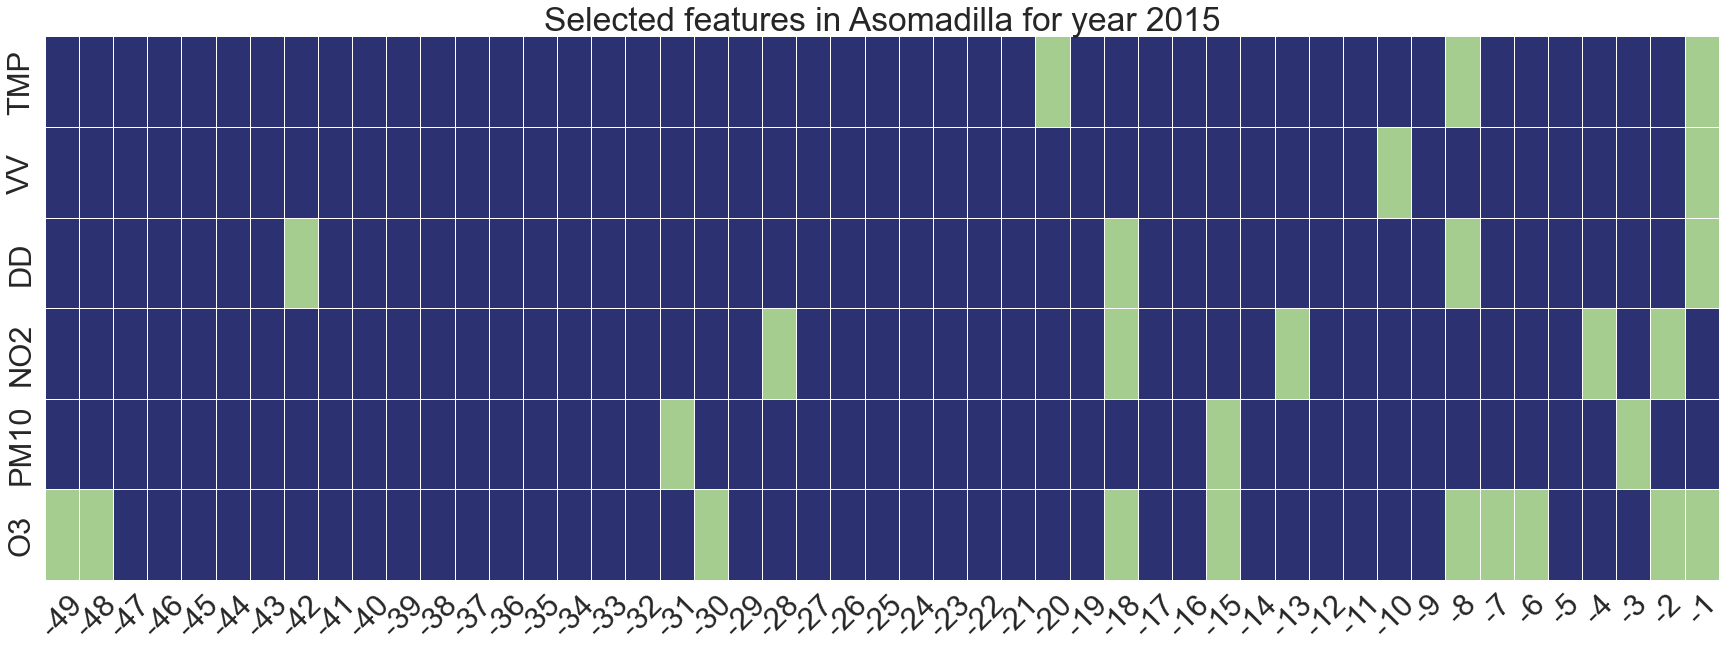

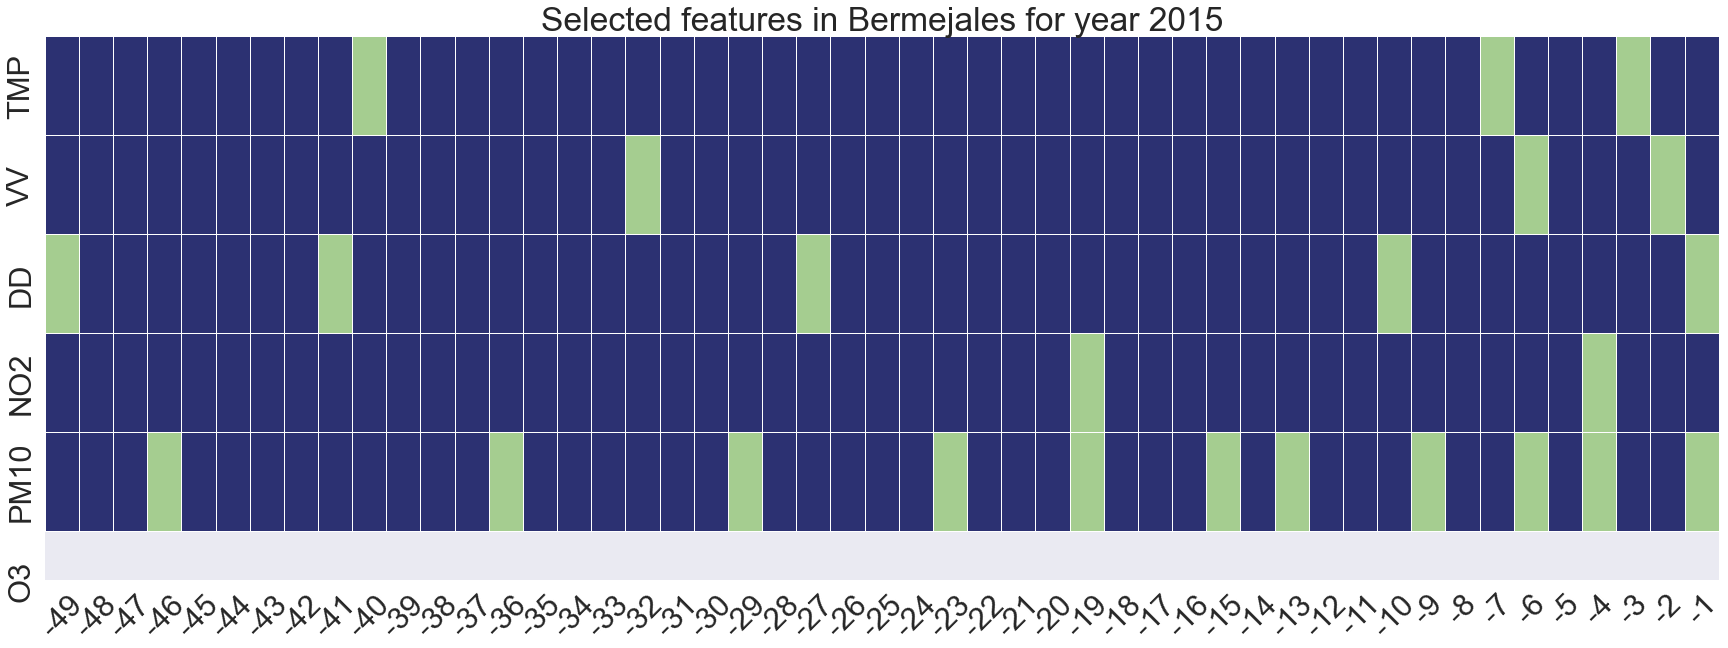

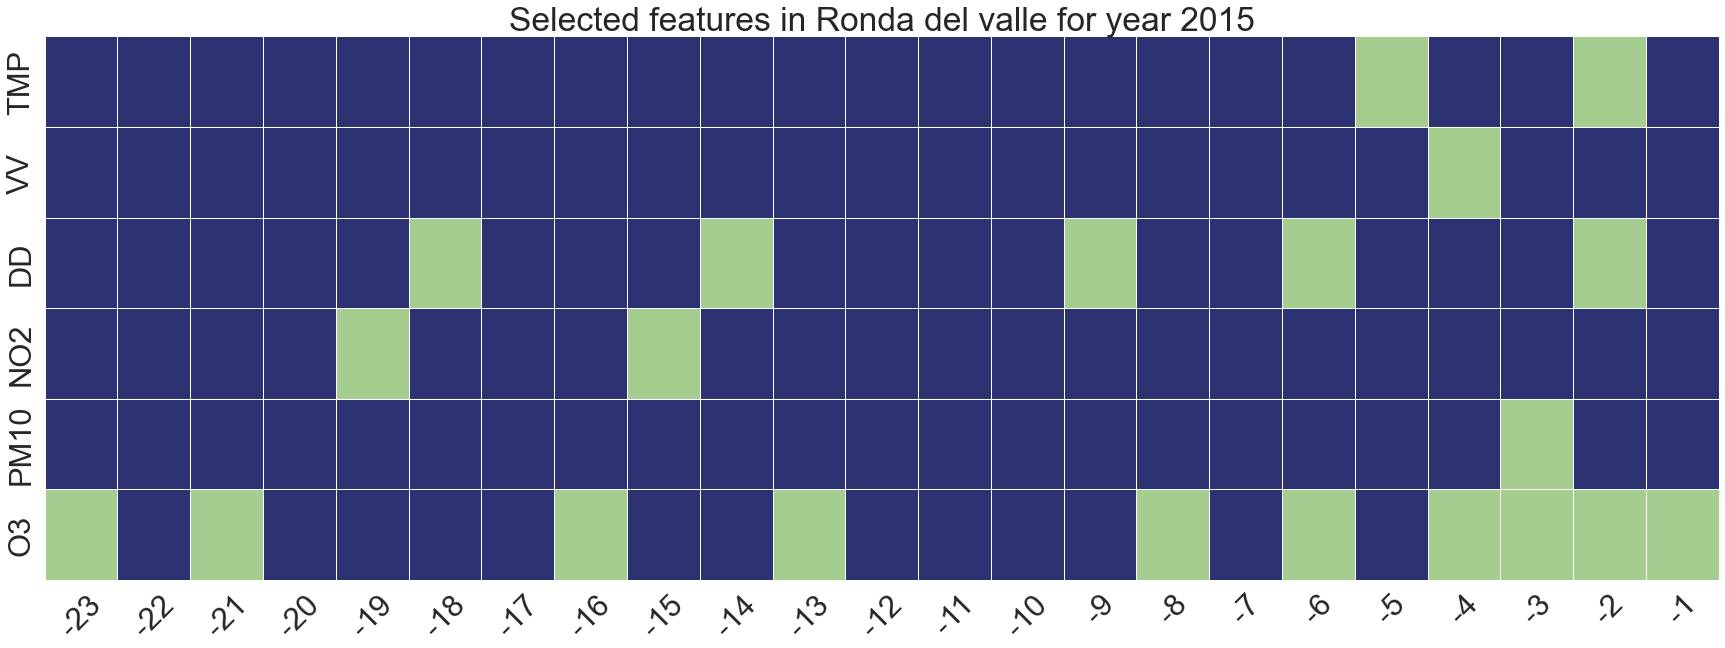

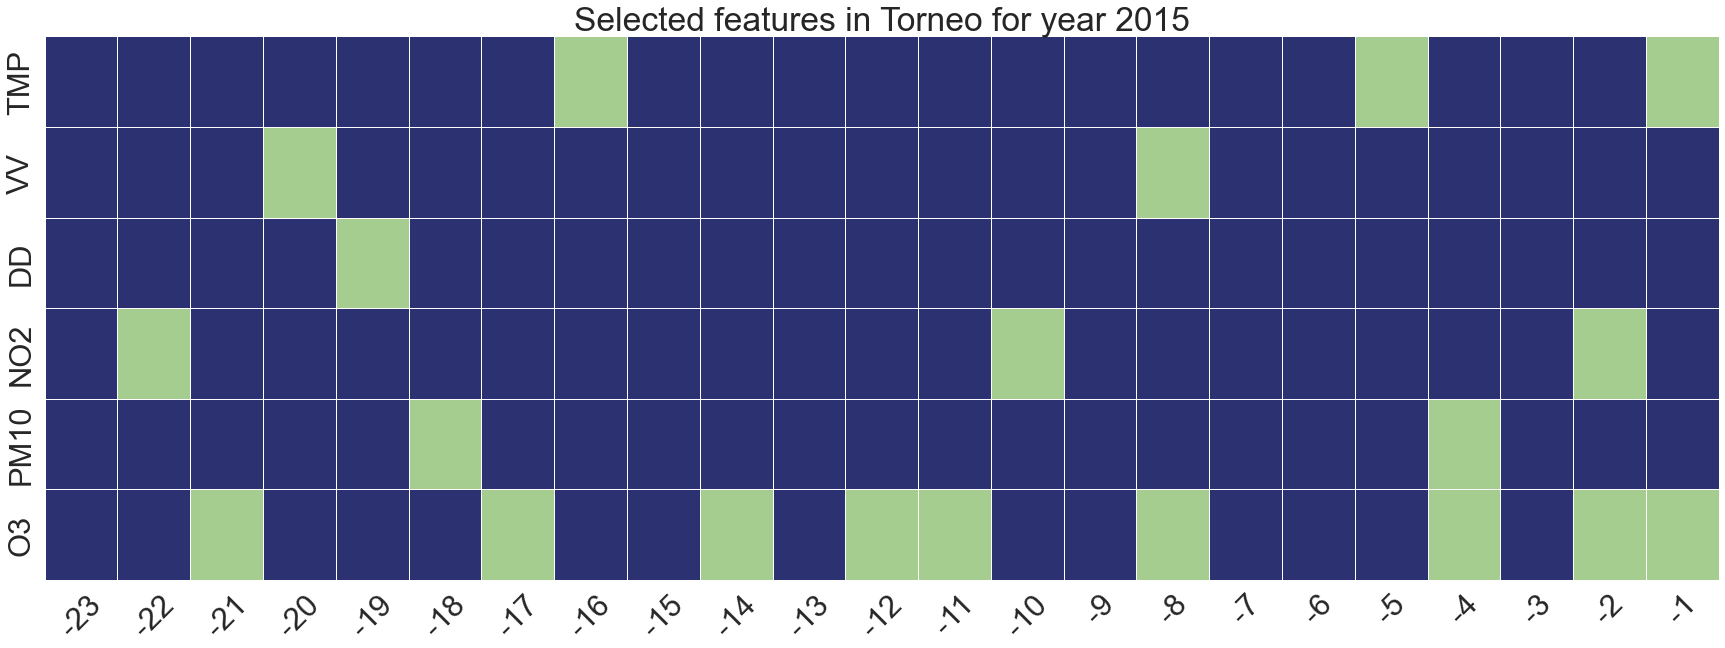

In [11]:
sns.set(font_scale=2.8)
best_by_year_selected = best_by_year[best_by_year.dataset_params_test_year>2005]

fetures_list = ['tmp', 'vv', 'dd', 'no2', 'pm10', 'o3']
for dataset in best_by_year_selected.dataset.unique():
    results_tsl_dataset = best_by_year_selected[(best_by_year_selected.dataset==dataset) & (best_by_year_selected.model_name=='TSL')].sort_values('dataset_params_test_year')
    results_tsl_dataset1 = best_by_year_selected[best_by_year_selected['dataset_params_test_year']==2015]
    features = results_tsl_dataset.features.apply(eval).apply(np.array).values[0]
    selected_features = results_tsl_dataset.selected_features.apply(eval).apply(np.array).values[0]

    selection_masks = []
    for feat in fetures_list:
        
        feats = features[np.core.defchararray.find(features, feat)!=-1]
        if len(feats)==0:
            continue
        sfeats = selected_features[np.core.defchararray.find(selected_features, feat)!=-1]

        
        mask = np.isin(feats, sfeats).astype(np.uint)
        selection_masks.append(mask)
    
    selection_masks = np.stack(selection_masks)
    print(selection_masks.sum()/(selection_masks.shape[0]*selection_masks.shape[1]))
    fig, ax = plt.subplots(figsize=(30,10))

    ax.set_title(f'Selected features in {dataset} for year 2015')
    cmap = sns.cm.crest_r
    g = sns.heatmap(selection_masks, yticklabels=list(map(lambda x: x.upper(), fetures_list)),cmap=cmap, xticklabels=list(map(lambda f: f.replace('target_o3 t', ''), feats.tolist())), cbar=False, linewidth=.5, ax=ax)
    plt.xticks(rotation=45)
    fig = g.get_figure()
    fig.savefig(f"figures/SelectionMasks/Ozone_{dataset}.png", bbox_inches='tight') 

## Results by year

In [26]:

best_metrics = total_metrics_indexed.loc[best_index].reset_index()
best_metrics = best_metrics.groupby(['dataset', 'model_name', 'dataset_params_test_year'], dropna=False)[['root_mean_squared_error']].mean().reset_index()
best_metrics = best_metrics.rename({'dataset_params_test_year': 'year'}, axis=1)
best_metrics = best_metrics[(best_metrics.year>2005)]
best_metrics.pivot(index = ['year'], columns=[ 'dataset','model_name'], values='root_mean_squared_error')#.round(1).to_latex()

dataset      Aljarafe                                                         \
model_name         DT         FF         L1     TSL_FF   TSL_LSTM       lstm   
year                                                                           
2006        17.243573  18.097287  17.504189  17.370430  17.371767  17.673223   
2007        17.159709  16.087352  15.775258  16.393498  16.103812  16.505806   
2008        17.493086  17.848675  16.953833  17.041665  16.964002  16.576066   
2009        17.605313  17.972382  16.844178  16.903659  17.432831  17.041117   
2010        17.982008  17.601217  17.127859  17.032473  16.418121  16.880089   
2011        16.826836  16.059551  15.918055  16.151403  15.325237  15.518323   
2012        17.942110  17.650049  17.116353  17.095485  16.986984  17.365391   
2013        16.278933  15.952952  15.495594  15.730044  14.985773  14.998649   
2014        16.483271  15.916625  15.770303  15.469246  15.540707  15.780022   
2015        16.701342  17.011578  18.161843  17.517470  16.117845  16.585964   

dataset    Asomadilla                                   ... Ronda del valle  \
model_name         DT         FF         L1     TSL_FF  ...              L1   
year                                                    ...                   
2006        18.660660  18.782416  17.477383  18.267150  ...       19.967508   
2007        17.475926  17.249166  16.534174  16.576121  ...       19.483785   
2008        18.323644  18.092122  17.293049  17.294268  ...       20.440460   
2009        17.103069  16.853762  16.305994  16.553617  ...       18.985219   
2010        17.276929  16.740519  16.172816  16.544854  ...       20.854387   
2011        17.037616  20.820474  16.842054  16.690493  ...       18.491692   
2012        17.217205  16.543894  15.912343  15.739251  ...       15.920868   
2013        16.258233  15.322899  15.022840  15.516028  ...       17.153151   
2014        16.992777  16.584707  16.221501  16.365175  ...       17.883680   
2015        16.864704  15.779429  15.598958  15.584481  ...       17.545885   

dataset                                         Torneo                        \
model_name     TSL_FF   TSL_LSTM       lstm         DT         FF         L1   
year                                                                           
2006        19.602784  19.680843  20.717376  14.581322  14.022648  13.335046   
2007        19.435887  19.176554  19.345461  14.391321  14.151125  13.386221   
2008        20.528995  19.972604  20.265408  14.530241  14.347429  13.267813   
2009        19.079250  18.708696  19.219115  15.092157  14.447162  14.145259   
2010        19.640781  20.052694  21.212567  15.215112  14.841071  14.457329   
2011        18.487949  18.521617  18.613008  14.835778  14.518871  14.361398   
2012        15.569511  15.121146  15.409758  15.588609  15.385036  14.979428   
2013        17.042538  16.936338  17.167467  15.146159  14.804227  14.394796   
2014        17.538782  17.355507  17.589939  15.103061  14.851430  14.278006   
2015        17.390608  17.074983  17.526724  15.303503  14.830067  14.829149   

dataset                                      
model_name     TSL_FF   TSL_LSTM       lstm  
year                                         
2006        13.083809  13.505647  13.458646  
2007        13.411364  13.285866  13.434802  
2008        13.619507  13.431704  13.821555  
2009        13.986262  14.071475  14.233385  
2010        14.538605  15.098950  15.217542  
2011        14.079702  13.953662  13.848558  
2012        14.596441  14.450207  14.612933  
2013        14.306195  13.967185  14.073849  
2014        14.030918  14.119907  13.910263  
2015        14.351173  14.303997  14.326489  

[10 rows x 30 columns]

## Bayesian tests

Aljarafe
(0.05076777275790345, 0.12935638999146104, 0.8198758372506355)
Asomadilla
(0.602895547675582, 0.10875292478995702, 0.288351527534461)
Bermejales
(0.03313082773446413, 0.12024413473288698, 0.8466250375326488)
Ronda del valle
(0.211954572140984, 0.23879189133067558, 0.5492535365283404)
Torneo
(0.9474553885433044, 0.044262588874285025, 0.00828202258241062)


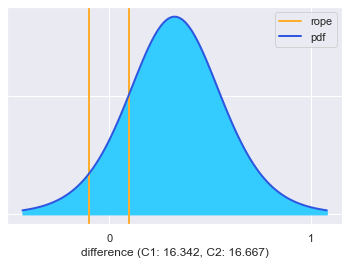

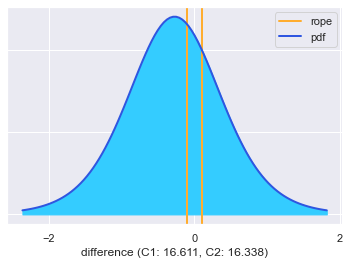

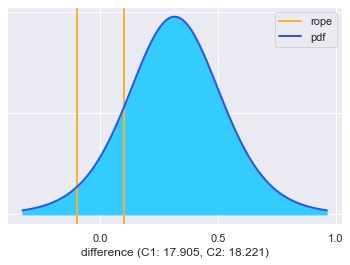

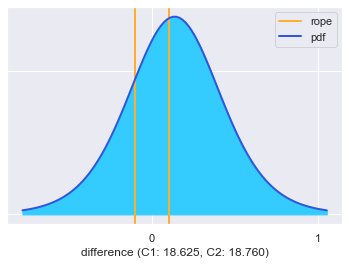

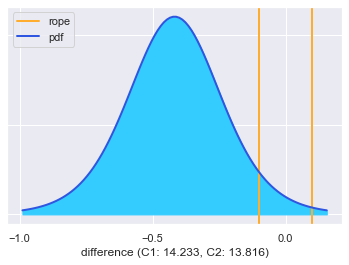

In [64]:
from baycomp import two_on_single


for dataset in best_metrics.dataset.unique():
    metrics_tsl = best_metrics[(best_metrics.dataset==dataset) & (best_metrics.model_name=='TSL')].root_mean_squared_error.values
    metrics_l1 = best_metrics[(best_metrics.dataset==dataset) & (best_metrics.model_name=='L1')].root_mean_squared_error.values
    probs, fig = two_on_single(metrics_tsl, metrics_l1, rope=0.1, plot=True)

    print(probs)
    fig.savefig(f"figures/Baytest/Baytest{dataset}.png") 

## Best hyperparameters

In [61]:
best_hyperparameters = best_index.to_frame()[['dataset', 'model_name']].reset_index(drop=True)
seq_lens = total_metrics_indexed.groupby(['dataset', 'model_name']).head(1)['dataset_params_seq_len'].reset_index(drop=True)

In [66]:
pd.set_option('display.max_colwidth', 2000)
seq_lens = total_metrics_indexed.groupby(['dataset', 'model_name']).head(1)['dataset_params_seq_len'].reset_index(drop=True)
params = list(map(lambda my_dict: {k: my_dict[k]for k in my_dict if not isnan(my_dict[k])},best_index.to_frame()[best_index.to_frame().model_name!='TSLRes'].loc[:, ['model_params_layers', 'model_params_units', 'model_params_batch_size', 'model_params_lr','model_params_dropout', 'selection_params_regularization']].to_dict('records')))
best_hyperparameters['window'] = seq_lens # 'model_params_max_depth', 'model_params_regularization',
best_hyperparameters['params'] = params

best_hyperparameters.set_index(['dataset', 'model_name'])#.to_latex('tab.tex')

window  \
dataset         model_name           
Aljarafe        FF              31   
                lstm            31   
                TSL_FF          28   
                TSL_LSTM        28   
Asomadilla      FF              31   
                lstm            31   
                TSL_FF          28   
                TSL_LSTM        28   
Bermejales      FF              31   
                lstm            31   
                TSL_FF          28   
                TSL_LSTM        28   
Ronda del valle FF              31   
                lstm            31   
                TSL_FF          28   
                TSL_LSTM        28   
Torneo          lstm            31   

                                                                                                                                                                                                                                                   params  
dataset         model_name                                                                                                                                                                                                                                 
Aljarafe        FF                                                                {'model_params_layers': 1, 'model_params_units': 35, 'model_params_batch_size': 117, 'model_params_lr': 0.0062097346448451, 'model_params_dropout': 0.2868397433361429}  
                lstm                                                               {'model_params_layers': 2, 'model_params_units': 12, 'model_params_batch_size': 90, 'model_params_lr': 0.0059068949009697, 'model_params_dropout': 0.2574445560291543}  
                TSL_FF      {'model_params_layers': 1, 'model_params_units': 16, 'model_params_batch_size': 95, 'model_params_lr': 0.0008125453689259, 'model_params_dropout': 0.2798584910270712, 'selection_params_regularization': 0.0096727665723697}  
                TSL_LSTM    {'model_params_layers': 1, 'model_params_units': 18, 'model_params_batch_size': 44, 'model_params_lr': 0.0058554533800052, 'model_params_dropout': 0.3719129270375464, 'selection_params_regularization': 0.0097002028888842}  
Asomadilla      FF                                                                {'model_params_layers': 1, 'model_params_units': 56, 'model_params_batch_size': 114, 'model_params_lr': 0.0004866423540055, 'model_params_dropout': 0.4473033317519236}  
                lstm                                                               {'model_params_layers': 1, 'model_params_units': 24, 'model_params_batch_size': 31, 'model_params_lr': 0.0017370065514576, 'model_params_dropout': 0.4036956443547619}  
                TSL_FF      {'model_params_layers': 1, 'model_params_units': 18, 'model_params_batch_size': 44, 'model_params_lr': 0.0058554533800052, 'model_params_dropout': 0.3719129270375464, 'selection_params_regularization': 0.0097002028888842}  
                TSL_LSTM    {'model_params_layers': 1, 'model_params_units': 36, 'model_params_batch_size': 29, 'model_params_lr': 0.0003802342314058, 'model_params_dropout': 0.0099400669198977, 'selection_params_regularization': 0.0024621860549236}  
Bermejales      FF                                                                {'model_params_layers': 1, 'model_params_units': 56, 'model_params_batch_size': 114, 'model_params_lr': 0.0004866423540055, 'model_params_dropout': 0.4473033317519236}  
                lstm                                                              {'model_params_layers': 2, 'model_params_units': 11, 'model_params_batch_size': 112, 'model_params_lr': 0.0014509067340407, 'model_params_dropout': 0.3735608213685923}  
                TSL_FF      {'model_params_layers': 1, 'model_params_units': 17, 'model_params_batch_size': 78, 'model_params_lr': 0.0013013002118332, 'model_params_dropout': 0.0682276128303425, 'selection_params_regularization': 0.0004456143302597}  
                TSL_LSTM    {